## Importação de Pacotes

In [1]:
#leitura da base de dados
import pandas as pd
from pathlib import Path

#modelo preditivo escolhido
from sklearn.ensemble import GradientBoostingClassifier

#validação cruzada
from sklearn.model_selection import train_test_split, GridSearchCV

#métricas
import matplotlib
from sklearn.metrics import accuracy_score, f1_score, recall_score, ConfusionMatrixDisplay

## Leitura do DataFrame

In [ ]:
direcao = Path("../..") / "data"
caminho = direcao / "df_tcu.csv"

df = pd.read_csv(caminho)

In [3]:
#transformando coluna númerica em float64 (no df original encontra-se como str)
df["materialidade_valor_envolvido"] = pd.to_numeric(df["materialidade_valor_envolvido"], errors= "coerce")

#invertendo os valores da coluna de admissibilidade
df["admissibilidade_concedida"] = df["admissibilidade_concedida"].replace({0: 1, 1: 0})

In [4]:
var_dependentes = ['admissibilidade_concedida', 'exame_sumario', 'perigo_demora', 'perigo_demora_reverso','plausibilidade_juridica', 'decisao_cautelar', 'oitiva', 'diligencia', 'oitiva_previa', 'merito']

df_dependentes = df[var_dependentes]
df_dependentes.columns

Index(['admissibilidade_concedida', 'exame_sumario', 'perigo_demora',
       'perigo_demora_reverso', 'plausibilidade_juridica', 'decisao_cautelar',
       'oitiva', 'diligencia', 'oitiva_previa', 'merito'],
      dtype='object')

In [5]:
df_independentes = df.drop(columns=var_dependentes)
df_independentes.columns

Index(['codigo', 'numeroCompleto', 'numero_only', 'ano', 'siglaTipoProcesso',
       'assunto', 'descricaoUnidadeResponsavelTecnica',
       'descricaoSubUnidadeResponsavelTecnica', 'siglaRelator',
       'dataAutuacaoFormatada', 'unidade_codigo', 'unidade_nome',
       'unidade_siglaUF', 'unidade_cidade', 'unidade_codigoSiafi',
       'representado_nome', 'representado_codigo', 'representante_nome',
       'representante_codigo', 'representante_cpf', 'representante_registro',
       'arquivo', 'estado_licitacao', 'data_instrucao',
       'materialidade_valor_envolvido', 'id', 'irregularidade_alegada',
       'categoria_de_proposta', 'partes_envolvidas', 'descricao_detalhada',
       'conduta', 'fundamento_legal', 'resultado_nexo_causal', 'evidencias',
       'particularidades_caso', 'resposta_ente_licitante',
       'ref_processo_associado', 'ref_tipo_referencia', 'ref_camara',
       'ref_numero_referencia', 'ref_origem_referencia',
       'ref_conteudo_julgado', 'ref_classificacao_r

## Pré-Processamento dos Dados

In [6]:
#Para fins deste notebook, a variável dependente escolhida é a coluna "admissibilidade_concedida"
#Objetivo é predizer em quais procedimentos no TCU foram cumpridos os pressupostos procedimentais

df_dummies = pd.get_dummies(df, columns=["categoria_de_proposta"], drop_first=True, dtype=int)

df_dummies = df_dummies.dropna(subset="materialidade_valor_envolvido")

lista_exclusao = [
    'codigo', 'numeroCompleto', 'numero_only', 'ano', 'siglaTipoProcesso',
    'assunto', 'descricaoUnidadeResponsavelTecnica',
    'descricaoSubUnidadeResponsavelTecnica', 'siglaRelator',
    'dataAutuacaoFormatada', 'unidade_codigo', 'unidade_nome',
    'unidade_siglaUF', 'unidade_cidade', 'unidade_codigoSiafi',
    'representado_nome', 'representado_codigo', 'representante_nome',
    'representante_codigo', 'representante_cpf', 'representante_registro',
    'arquivo', 'estado_licitacao', 'data_instrucao', 'id', 'irregularidade_alegada',
    'partes_envolvidas', 'descricao_detalhada', 'conduta', 'fundamento_legal',
    'resultado_nexo_causal', 'evidencias', 'particularidades_caso',
    'resposta_ente_licitante', 'ref_processo_associado', 'ref_tipo_referencia',
    'ref_camara', 'ref_numero_referencia', 'ref_origem_referencia',
    'ref_conteudo_julgado', 'ref_classificacao_referencia',
    'ref_resultado_utilizacao', 'arquivo_sem_json', 'numero_processo',
    'apreciou_cautelar', 'admissibilidade_concedida', 'exame_sumario', 'perigo_demora',
    'perigo_demora_reverso', 'plausibilidade_juridica', 'decisao_cautelar',
    'oitiva', 'diligencia', 'oitiva_previa', 'merito'
]


In [7]:
X = df_dummies.drop(columns=lista_exclusao, axis=1) #variáveis independentes são "materialidade_valor_envolvido" e "categoria_de_proposta"
y = df_dummies["admissibilidade_concedida"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=22)

## Ajuste do Modelo

In [8]:
gradient_boost = GradientBoostingClassifier()

gradient_boost.fit(X_train, y_train)

gradient_boost

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


### **Métricas**

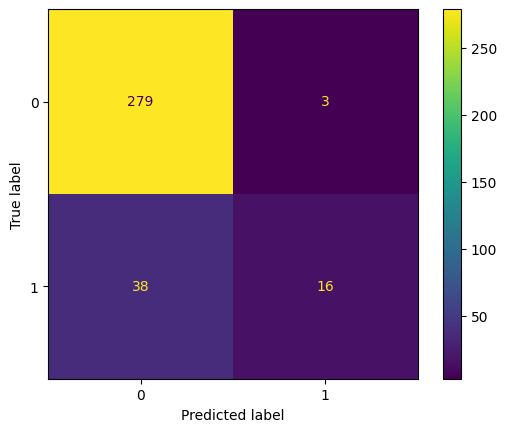

In [9]:
ConfusionMatrixDisplay.from_estimator(gradient_boost, X_test, y_test)

In [10]:
y_pred = gradient_boost.predict(X_test)

acuracia = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"""
      Acurária: {round(acuracia,3)};
      F1: {round(F1,3)};
      Revocação: {round(recall,3)}
      """)


      Acurária: 0.878;
      F1: 0.438;
      Revocação: 0.296
      


## Aplicando Validação Cruzada

In [11]:
parametros = {"n_estimators": [100, 200, 500, 1000], "max_depth": [1, 2, 3, 4, 5], "max_leaf_nodes": [None, 10, 20, 30, 50],"learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0]}

grid = GridSearchCV(gradient_boost, parametros, scoring="roc_auc", cv=5)

grid.fit(X_train, y_train)

gradient_boost_CV = grid.best_estimator_

gradient_boost_CV.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.5
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,2
,min_impurity_decrease,0.0
,init,None


### **Métricas**

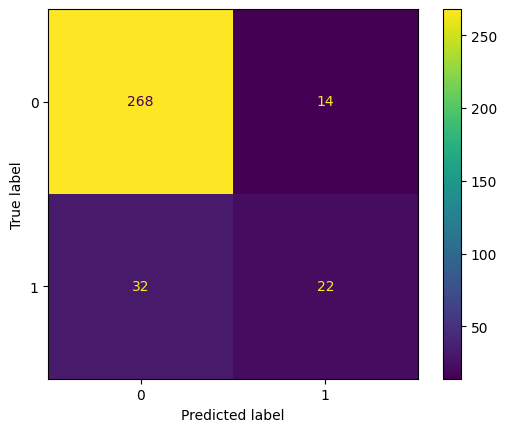

In [12]:
ConfusionMatrixDisplay.from_estimator(gradient_boost_CV, X_test, y_test)

In [13]:
y_pred = gradient_boost_CV.predict(X_test)

acuracia = accuracy_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"""
      Acurária_CV: {round(acuracia,3)};
      F1_CV: {round(F1,3)};
      Revocação_CV: {round(recall,3)}""")


      Acurária_CV: 0.863;
      F1_CV: 0.489;
      Revocação_CV: 0.407
